In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Install NLTK
!pip install nltk
import nltk
nltk.download('vader_lexicon')

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Fetched 2,355 kB in 3s (673 kB/s)
Reading package lists... Done


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.sentiment import SentimentIntensityAnalyzer

import pyspark
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [3]:
# Load the data
df = pd.read_csv('/content/Amazon_Product_Reviews.csv')
df.head()

,Product ID,Product Name,Asins,Categories,Review Date,Recommended,Reviews_Helpful,Reviews_Ratings,Review_Text,Review_Title
0,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-09-03T00:00:00.000Z,False,0,3,I thought it would be as big as small paper bu...,Too small
1,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-06-06T00:00:00.000Z,True,0,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-20T00:00:00.000Z,True,0,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-11-02T17:33:31.000Z,True,3,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-24T00:00:00.000Z,True,0,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [4]:
# Check the value count of each rating
df['Reviews_Ratings'].value_counts()

Reviews_Ratings
5    3478
4    1208
3     197
1      63
2      54
Name: count, dtype: int64

In [5]:
# Drop unnecessary columns in dataset
df.drop(['Product ID', 'Reviews_Helpful'], axis=1, inplace=True)
df.head()

,Product Name,Asins,Categories,Review Date,Recommended,Reviews_Ratings,Review_Text,Review_Title
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-09-03T00:00:00.000Z,False,3,I thought it would be as big as small paper bu...,Too small
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-06-06T00:00:00.000Z,True,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-20T00:00:00.000Z,True,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-11-02T17:33:31.000Z,True,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-24T00:00:00.000Z,True,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [6]:
# Assign a sentiment category (positive, neutral, or negative) based on review ratings
# Map these sentiments to numerical values (positive: 1, negative: 2, neutral: 0) in a new column.
def assign_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'
df['sentiment'] = df['Reviews_Ratings'].apply(assign_sentiment)
df['sentiment_num'] = df["sentiment"].map({'positive':1, 'negative':2, 'neutral':0 }).values

In [7]:
df.head()

,Product Name,Asins,Categories,Review Date,Recommended,Reviews_Ratings,Review_Text,Review_Title,sentiment,sentiment_num
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-09-03T00:00:00.000Z,False,3,I thought it would be as big as small paper bu...,Too small,neutral,0
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-06-06T00:00:00.000Z,True,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,positive,1
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-20T00:00:00.000Z,True,4,Didnt know how much i'd use a kindle so went f...,Great for the price,positive,1
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-11-02T17:33:31.000Z,True,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,positive,1
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-24T00:00:00.000Z,True,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,positive,1


Analyzing the 'Sentiment_num'

In [8]:
# Find distinct values of sentiments
df.sentiment_num.value_counts()

sentiment_num
1    4686
0     197
2     117
Name: count, dtype: int64

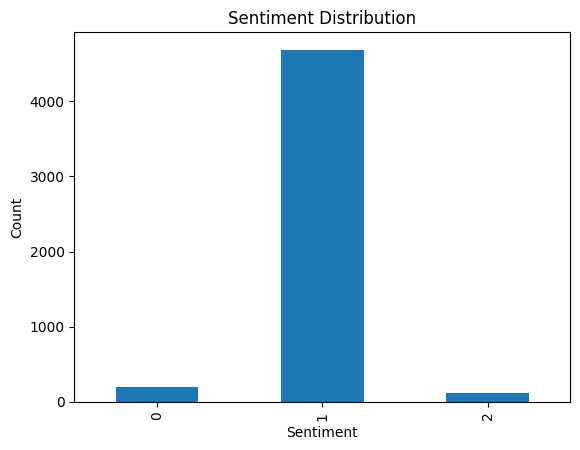

In [9]:
# Plot sentiment_num
df['sentiment_num'].value_counts().sort_index().plot.bar()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

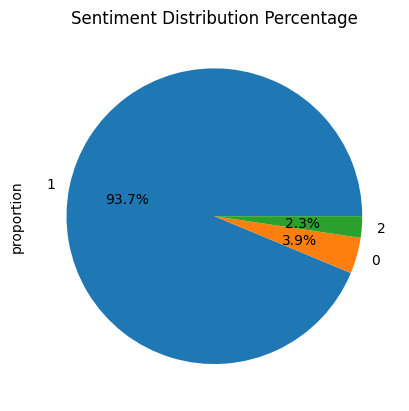

In [10]:
#Plot sentiment_num percentage
sentiment_percentages = df['sentiment_num'].value_counts(normalize=True) * 100
sentiment_percentages.plot.pie(autopct='%1.1f%%')
plt.title('Sentiment Distribution Percentage')
plt.show()

In [11]:
# Drop unnecessary columns, rename columns
text_df = df.drop(['Review Date', 'Recommended', 'sentiment', 'sentiment_num'], axis=1)
text_df = text_df.rename(columns ={'Product Name': 'product_name', 'Review_Text' : 'reviews','Reviews_Ratings' : 'ratings', 'Review_title' : 'title', 'Categories': 'product_type'})
text_df.head()

,product_name,Asins,product_type,ratings,reviews,Review_Title
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,3,I thought it would be as big as small paper bu...,Too small
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [12]:
text_df.describe()

,ratings
count,5000.000000
mean,4.596800
std,0.731804
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [21]:
# Set the 'ratings' column to 0 if the rating is less than 3, and set the 'ratings' column to 1 if greater than 3
text_df['ratings'] = text_df['ratings'].apply(lambda x: 0 if x < 3 else 1)

In [22]:
text_df.head()

,product_name,Asins,product_type,ratings,reviews,Review_Title
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,0,I thought it would be as big as small paper bu...,Too small
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,0,Didnt know how much i'd use a kindle so went f...,Great for the price
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,0,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [30]:
# Split the data into features
y = df['ratings'].values
X = df.drop(['ratings'],axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

KeyError: 'ratings'